In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pywt
from torch.utils.data import DataLoader, Dataset , Subset
from torch import nn
import torch
import pickle
import os
from datetime import datetime
import sqlite3
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.tensorboard import SummaryWriter



from torchmetrics.functional.classification.accuracy import accuracy


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on device: {device}')

Training on device: cuda


In [3]:
class CWTDataset(Dataset):
    def __init__(self, db_path, sequence_length=4000):
        self.db_path = db_path
        self.sequence_length = sequence_length
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.cursor.execute("SELECT COUNT(*) FROM wavelet_transforms")
        self.total_samples = self.cursor.fetchone()[0]

    def __len__(self):

        return self.total_samples - self.sequence_length + 1

    def __getitem__(self, idx):

        query = (
            "SELECT cwt_data, target FROM wavelet_transforms WHERE id BETWEEN ? AND ?"
        )

        self.cursor.execute(query, (idx + 1, idx + self.sequence_length))
        rows = self.cursor.fetchall()

        cwt_sequence = np.stack([pickle.loads(row[0]) for row in rows])

        target = rows[-1][1]

        cwt_tensor = torch.tensor(cwt_sequence, dtype=torch.float32)

        target_tensor = torch.tensor(target, dtype=torch.int64)
        return cwt_tensor, target_tensor

    def __del__(self):
        self.conn.close()

In [4]:
class CWTSubset(Dataset): 
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        row = self.dataset.__getitem__(int(self.indices[idx]))
        return row
    def __len__(self):
        return len(self.indices)

In [5]:
class CWT_EEG(LightningModule):
    def __init__(
        self,
        batch_size,
        sequence_length,
        input_size,
        hidden_size,
        num_layers,
        lr,
        label_smoothing=0,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.hparams.batch_size = batch_size
        self.hparams.input_size = input_size
        self.hparams.sequence_length = sequence_length
        self.hparams.lr = lr
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_of_classes = 3
        self.val_percent = 0.01
        self.loss = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, self.num_of_classes)  

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = hn[-1, :, :]  
        out = self.fc(out)

        return out

    # custom
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # only for HP
    def on_train_start(self):
        self.logger.log_hyperparams(
            self.hparams,
            {
                "hp/train_loss": float("nan"),
                "hp/train_acc": float("nan"),
                "hp/val_loss": float("nan"),
                "hp/val_acc": float("nan"),
            },
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_of_classes)

        self.log("hp/train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("hp/train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_of_classes)

        self.log("hp/val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("hp/val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def create_train_val_split(self, data_length, val_percent, sequence_length):
        available_lenght = data_length - sequence_length
        val_count = int(val_percent * available_lenght)
        all_indices = np.arange(available_lenght)
        val_indices = np.sort(
            np.random.choice(all_indices, size=val_count, replace=False)
        )
        mask = np.ones(available_lenght, dtype=bool)
        for idx in val_indices:
            start = max(0, idx - sequence_length + 1)
            end = min(available_lenght, idx + sequence_length)
            mask[start:end] = False
        train_indices = list(np.where(mask)[0])
        val_indices = list(val_indices)
        return train_indices, val_indices

    def setup(self, stage=None):
        self.ds = CWTDataset("cwt_data.db", self.hparams.sequence_length)
        train_indices, val_indices = self.create_train_val_split(
            len(self.ds), self.val_percent, self.hparams.sequence_length
        )
        self.train_set = CWTSubset(self.ds, train_indices)
        self.val_set = CWTSubset(self.ds, val_indices)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            batch_size=self.hparams.batch_size,
            num_workers=14,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_set, batch_size=self.hparams.batch_size, num_workers=14
        )

    def get_len_train_val(self):
        self.setup()
        return len(self.train_set), len(self.val_set)

In [6]:
lr = 0.001

model = CWT_EEG( batch_size= 11 ,sequence_length =10,input_size=640 , num_layers=3,hidden_size=3, lr=lr).to(device)
logger = TensorBoardLogger("lightning_logs", name="CWT_EEG",default_hp_metric=False)
logger.log_hyperparams(model.hparams, {})
trainer = Trainer(
    max_epochs=1,
    logger=logger

)
print(model.get_len_train_val())
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


(64453, 779)


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | loss | CrossEntropyLoss | 0     
1 | lstm | LSTM             | 7.9 K 
2 | fc   | Linear           | 12    
------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


Epoch 0:   6%|▌         | 327/5868 [00:08<02:21, 39.12it/s, v_num=132, hp/train_loss_step=0.993, hp/train_acc_step=0.545] 

/home/daniel/miniconda3/envs/EEG311/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [8]:
# Utworzenie folderu dla logów
writer = SummaryWriter('./lightning_logs/CWT_EEG')

In [10]:
dummy_input = torch.randn(11, 10,640).to(device)  # Przykładowe dane wejściowe (batch_size, input_size)
writer.add_graph(model, dummy_input)
writer.close()

In [30]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Warstwa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size)


    def forward(self, input_seq):
        # Inicjalizacja stanu ukrytego i stanu komórki
        # (num_layers * num_directions, batch, hidden_size)
        h0 = torch.zeros(1, input_seq.size(1), self.hidden_size)
        c0 = torch.zeros(1, input_seq.size(1), self.hidden_size)

        # Przejście przez LSTM
        lstm_out, _ = self.lstm(input_seq, (h0, c0))


        return lstm_out

# Parametry modelu
input_size = 20  # Wymiary wejściowe (np. cechy)
hidden_size = 10  # Wymiary stanu ukrytego LSTM


# Tworzenie instancji modelu
model = SimpleLSTM(input_size, hidden_size )

dummy_input = torch.randn( 1, 10, 20)  # Przykładowe dane wejściowe (batch_size, input_size)
writer.add_graph(model, dummy_input)
writer.close()
# Wyświetlenie struktury modelu
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


1280


In [ ]:
def create_train_val_split(data_length, val_percent, sequence_length):
    available_lenght = data_length - sequence_length
    val_count = int(val_percent * available_lenght)
    all_indices = np.arange(available_lenght)
    val_indices = np.sort(np.random.choice(all_indices, size=val_count, replace=False))
    mask = np.ones(available_lenght, dtype=bool)
    for idx in val_indices:
        start = max(0, idx - sequence_length + 1)
        end = min(available_lenght, idx + sequence_length)
        mask[start:end] = False
    train_indices = np.where(mask)[0]
    # convert evry number to int
    train_indices = list(train_indices)
    val_indices = list(val_indices)

    return train_indices, val_indices

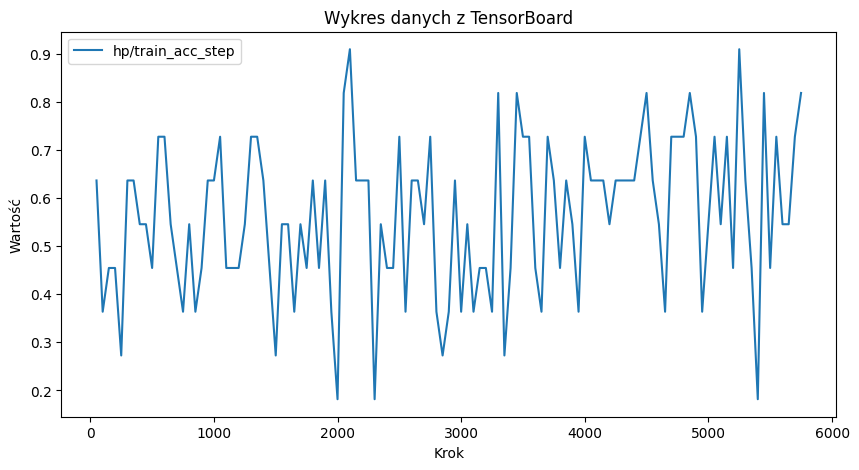

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def load_tensorboard_scalars(logdir):
    # Tworzy akumulator do odczytu danych
    ea = event_accumulator.EventAccumulator(logdir,
        size_guidance={event_accumulator.SCALARS: 0})  # 0 = bez ograniczeń
    ea.Reload()  # Wczytaj wszystkie dane z dysku

    # Odczyt danych skalarnych
    scalars = {}
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        scalars[tag] = [(e.wall_time, e.step, e.value) for e in events]

    return scalars

# Ścieżka do katalogu z logami TensorBoard
logdir = '/home/daniel/repos/Decoding_of_EEG/lightning_logs/CWT_EEG/version_51/events.out.tfevents.1713204451.pop-os.32833.5'

# Wczytanie danych
scalars = load_tensorboard_scalars(logdir)

# Przykład wyświetlenia danych skalarnych
tag = 'hp/train_acc_step'  # Zmień na odpowiedni tag, który chcesz wyświetlić
times, steps, values = zip(*scalars[tag])

plt.figure(figsize=(10, 5))
plt.plot(steps, values, label=tag)
plt.xlabel('Krok')
plt.ylabel('Wartość')
plt.title('Wykres danych z TensorBoard')
plt.legend()
plt.show()


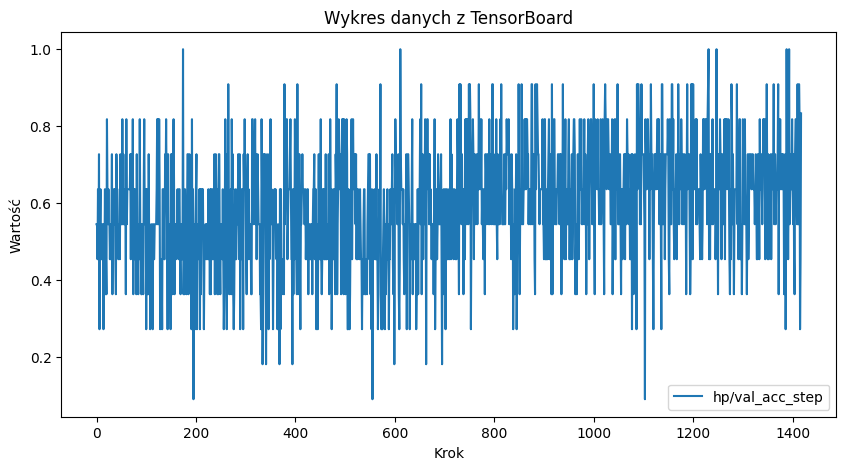

In [ ]:
tag = 'hp/val_acc_step'  # Zmień na odpowiedni tag, który chcesz wyświetlić
times, steps, values = zip(*scalars[tag])

plt.figure(figsize=(10, 5))
plt.plot(steps, values, label=tag)
plt.xlabel('Krok')
plt.ylabel('Wartość')
plt.title('Wykres danych z TensorBoard')
plt.legend()
plt.show()